### Step 0: Initializing Torch and Verifying GPU

In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

device

0
1
NVIDIA GeForce GTX 1650 Ti


device(type='cuda', index=0)

### Question 1: Simulation of Multivariate Normal Distribution

In [2]:
import matplotlib.pyplot as plt

def bivariate_gaussian_distribution(m=1000, plot=True):

  #Define the variables
  mu_a = torch.tensor([-0.5, -0.5])
  cov_a = torch.tensor([[1, 0.25], [0.25, 1]])
  mu_b = torch.tensor([0.5, 0.5])
  cov_b = torch.tensor([[1, 0.25], [0.25, 1]])

#Get the 2 distribution samples
  x_a = torch.distributions.MultivariateNormal(mu_a, cov_a).sample((m,))
  x_b = torch.distributions.MultivariateNormal(mu_b, cov_b).sample((m,))

  if plot:
    Xa_np = x_a.numpy()
    Xb_np = x_b.numpy()
    #Create scatter plot of the combined data
    plt.scatter(Xa_np[:, 0], Xa_np[:, 1], color='purple', label='A')
    plt.scatter(Xb_np[:, 0], Xb_np[:, 1], color='yellow', label='B')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Bivariate Normal Distributions')
    plt.show()

  #Stack the two samples
  X = torch.vstack((x_a, x_b))

  return X

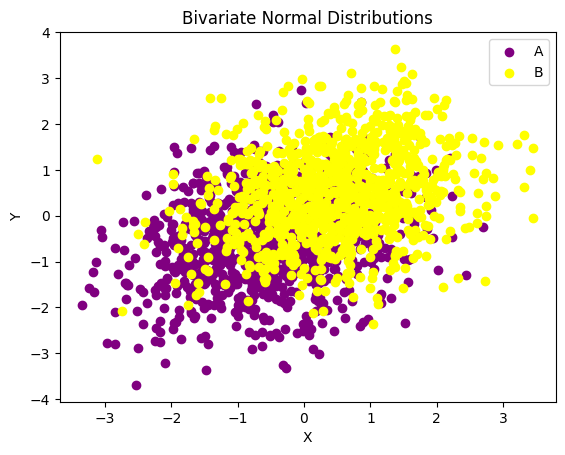

In [3]:
#Plot the 2 distributions
_ = bivariate_gaussian_distribution()

### Question 2: K-Means Clustering

In [4]:
#Initialize random centroids
def random_centroids(X, k):
    indices = torch.randperm(X.size(0))[:k]
    return X[indices]

#Compute the label for each datapoint
def get_labels(X, centroids):
    distances = torch.cdist(X, centroids)
    return torch.argmin(distances, dim=1)

#Update centroid Values
def new_centroids(X, labels, k):
    centroids = []
    for i in range(k):
        cluster_points = X[labels == i]
        cluster_points = cluster_points + 1e-10
        centroid = torch.exp(torch.log(cluster_points).mean(0))
        centroids.append(centroid)
    return torch.stack(centroids)

#Vizualize the clusters
def plot_clusters(X, labels, centroids):
    X_np = X.numpy()
    labels_np = labels.numpy()
    centroids_np = centroids.numpy()
    plt.scatter(X_np[:, 0], X_np[:, 1], c=labels_np, cmap='viridis', label='Data Points')
    plt.scatter(centroids_np[:, 0], centroids_np[:, 1], color='red', marker='x', label='Centroids')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('K-means Clustering Result')
    plt.legend()
    plt.show()

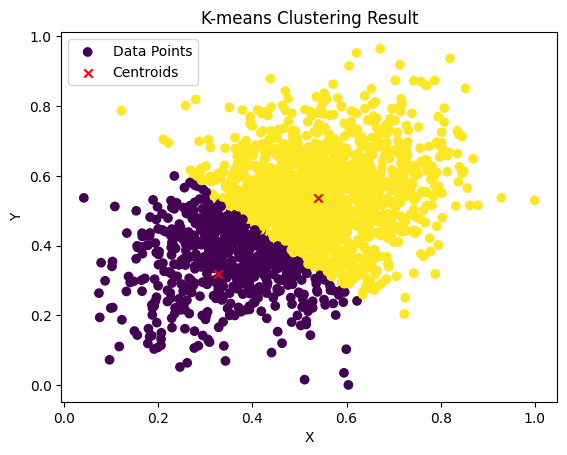

In [5]:
X_combined = bivariate_gaussian_distribution(plot=False)

#Normalize the data
X = ((X_combined - X_combined.min()) / (X_combined.max() - X_combined.min() + 1e-10))

#Define KMeans Algorithm Parameters
max_iterations = 100
k = 2

#Initialize Kmeans Algorithm variables
old_centroids = torch.tensor(0)
iteration = 1

#Get the random centroid coordinates
centroids = random_centroids(X, k)

#Iterate to find the optimal centroids
while iteration < max_iterations and not centroids.equal(old_centroids):
    old_centroids = centroids
    labels = get_labels(X, centroids)
    centroids = new_centroids(X, labels, k)

plot_clusters(X, labels, centroids)

### Question 3: Projection with Principal Components Analysis (PCA)

In [6]:
#Generate synthetic data
X = torch.distributions.Normal(0, 1).sample((100, 4))
X[:, 2] = 3 * X[:, 0] - 2 * X[:, 1] + torch.distributions.Normal(0, 0.1).sample((100,))
X[:, 3] = 1.5 * X[:, 0] - 0.5 * X[:, 1] + torch.distributions.Normal(0, 0.1).sample((100,))

In [7]:
#Apply zero mean
X = X - X.mean(0)
X_np = X.numpy()

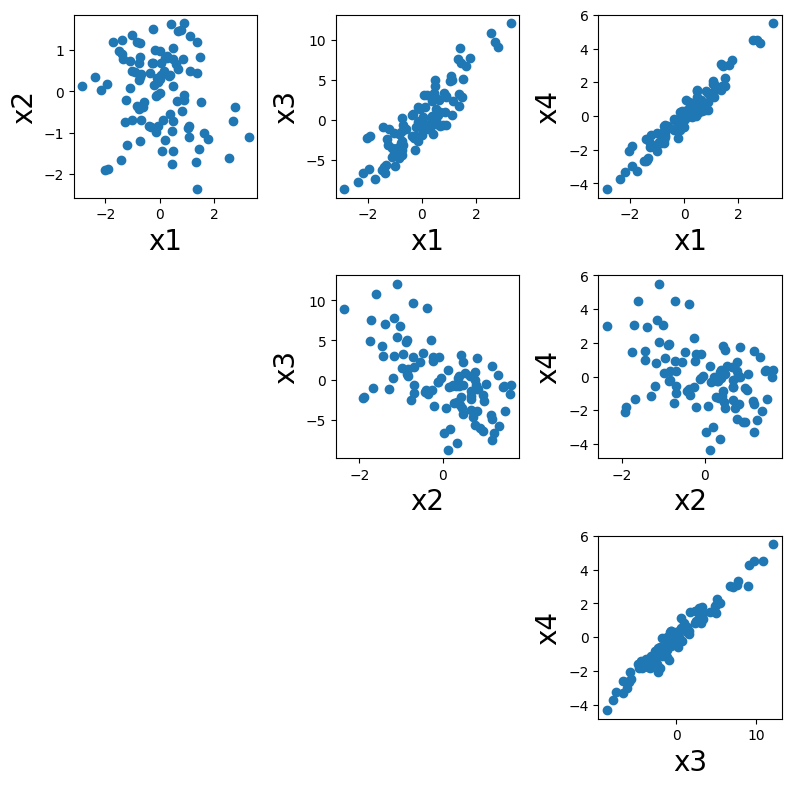

In [8]:
#Vizualize distribution
plt.figure(figsize=(10,10))
for i in range(4):
    for j in range(4):
        if j > i:
            plt.subplot(4,4,i*4+j+1)
            plt.scatter(X[:,i], X[:,j])
            plt.xlabel(f'x{i+1}', fontsize=20)
            plt.ylabel(f'x{j+1}', fontsize=20)
plt.tight_layout()

In [9]:
#Compute Covariance Matrix
cov_matrix = sum([X[i].reshape(-1,1) @ X[i].reshape(1,-1) for i in range(100)]) / 100
cov_matrix = cov_matrix.float()

In [10]:
# Compute eigenvalues and eigenvectors of the covariance matrix
eigvals, eigvecs = torch.linalg.eig(cov_matrix)
eigvals = eigvals.real

In [11]:
#Sort order by magnitude of eigenvalue
ordering = torch.argsort(eigvals, descending=True)

In [12]:
# Get sorted eigenvectors
principal_components = eigvecs[:, ordering]
print("Principal Components:")
print(principal_components.numpy())

Principal Components:
[[ 0.22223881+0.j -0.47837692+0.j  0.22664034+0.j -0.8187803 +0.j]
 [-0.11133486+0.j -0.799262  +0.j  0.28694898+0.j  0.5161816 +0.j]
 [ 0.88881177+0.j  0.16083558+0.j  0.3524254 +0.j  0.24482942+0.j]
 [ 0.38500407+0.j -0.32629377+0.j -0.8614469 +0.j  0.0566917 +0.j]]


/workspaces/eng-ai-agents/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/workspaces/eng-ai-agents/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


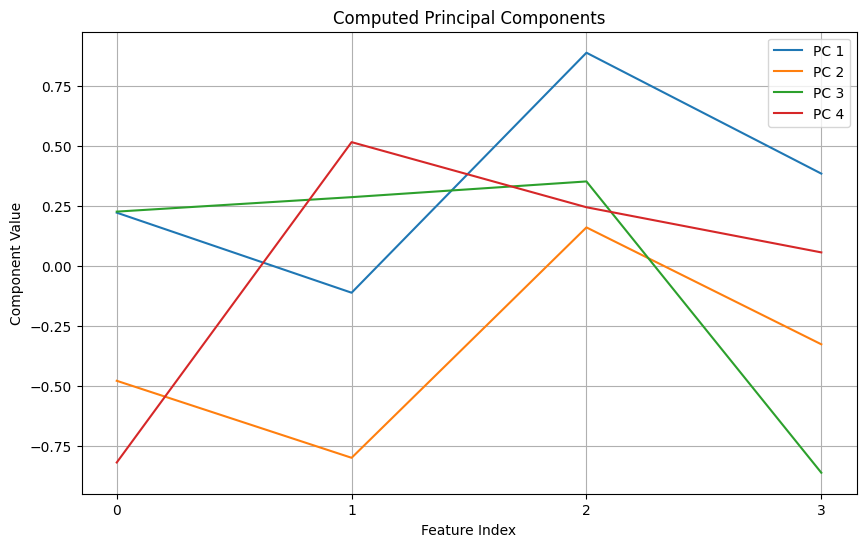

In [13]:
plt.figure(figsize=(10, 6))
for i in range(principal_components.shape[1]):
    plt.plot(principal_components[:, i].numpy(), label=f'PC {i+1}')
plt.title("Computed Principal Components")
plt.xticks(ticks=[0, 1, 2, 3])
plt.xlabel('Feature Index')
plt.ylabel('Component Value')
plt.legend()
plt.grid(True)
plt.show()